## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [10]:
import os

import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [3]:
import scipy as sp

In [4]:
import math
import numpy as np

In [5]:
import scanpy as sc

In [8]:
import harmonypy as hm
import pyliger
import scanorama

In [7]:
import scib

## Load data and view the data without integration

In [12]:
adatas = []

ids = ["H18.06.006.MTG.4000.expand.rep1",
       "H18.06.006.MTG.4000.expand.rep2",
       "H18.06.006.MTG.4000.expand.rep3",
       "H22.26.401.MTG.4000.expand.rep1",
       "H22.26.401.MTG.4000.expand.rep2",
       "H19.30.001.STG.4000.expand.rep1",
       "H19.30.001.STG.4000.expand.rep2",
       "H20.30.001.STG.4000.expand.rep1",
       "H20.30.001.STG.4000.expand.rep2",
       "H20.30.001.STG.4000.expand.rep3"]

for id in ids:
    data_dir = '../../data/human-brain/'
    obs = pd.read_csv(os.path.join(data_dir, f"{id}.features.csv"), index_col=0)
    var = pd.read_csv(os.path.join(data_dir, f"{id}.genes.csv"), index_col=0)
    data = pd.read_csv(os.path.join(data_dir, f"{id}.matrix.csv"))

    temp_adata = sc.AnnData(X=sp.sparse.csr_matrix((data['val'], (data['col'] - 1, data['row'] - 1)), 
                                               shape=(len(obs), len(var))),
                       obs=obs,
                       var=var)
    temp_adata.obs['sample'] = id
    adatas.append(temp_adata)

## PCA (w/o correction)

In [13]:
adata = sc.concat(adatas)

In [17]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.raw = adata.copy()
sc.pp.scale(adata)

In [18]:
sc.tl.pca(adata)

In [19]:
sc.pp.neighbors(adata)

In [20]:
sc.tl.umap(adata)

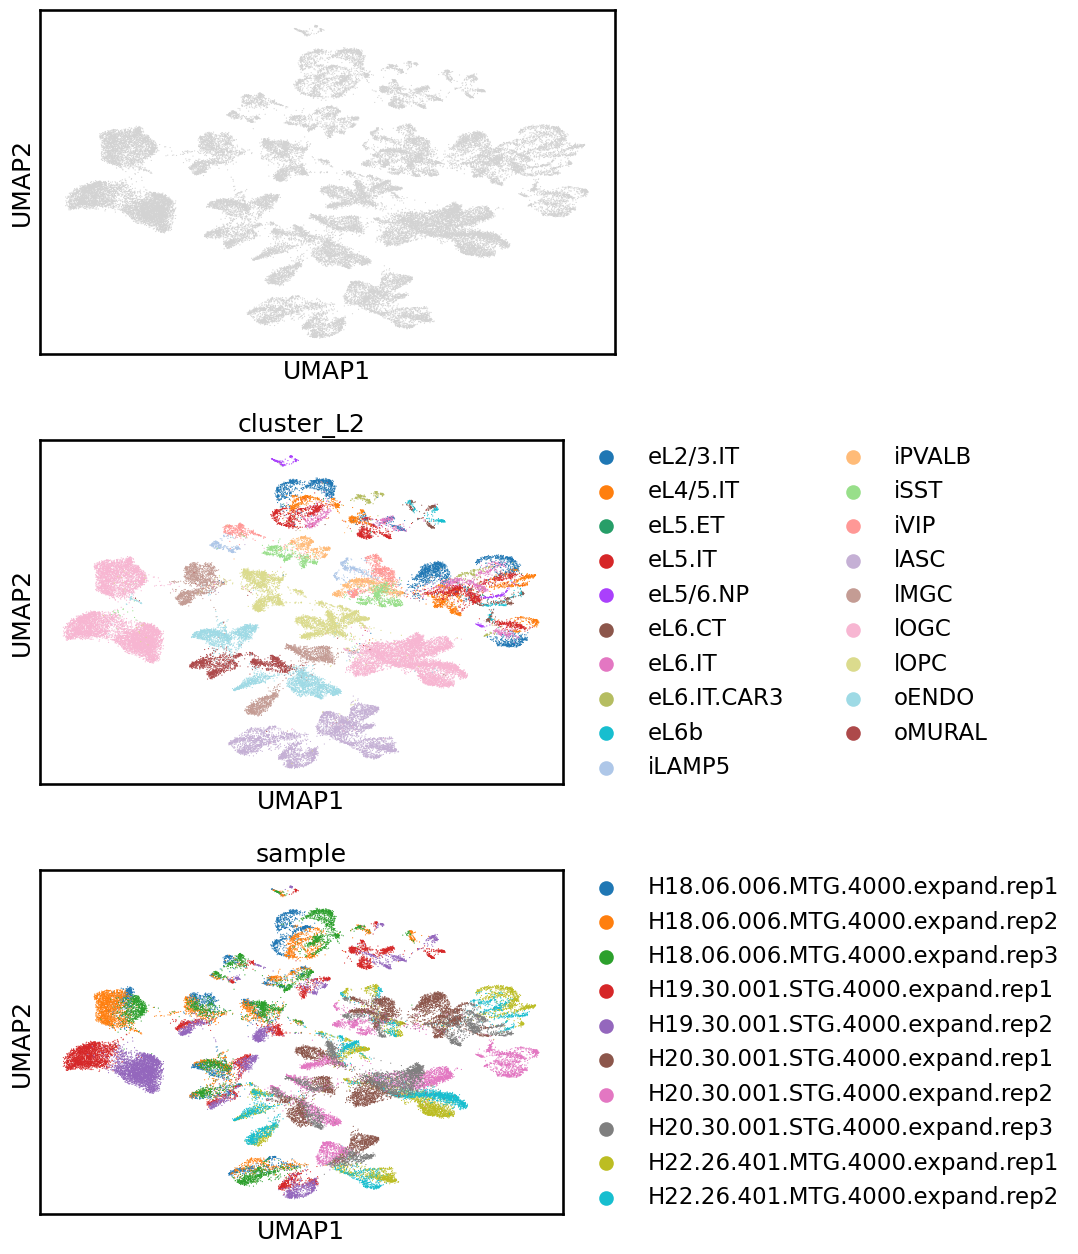

In [25]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cluster_L2', 'sample'], ncols=1)
pass

## Harmony integration

In [27]:
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs[['sample']], ['sample'])

2023-10-03 12:17:21,714 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-10-03 12:17:35,988 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-10-03 12:17:36,224 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-10-03 12:17:52,686 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-10-03 12:18:09,645 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-10-03 12:18:25,855 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-10-03 12:18:42,677 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2023-10-03 12:18:52,026 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2023-10-03 12:18:59,723 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2023-10-03 12:19:06,334 - 

In [28]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_harmony'] = res.to_numpy().T

In [ ]:
sc.pp.neighbors(adata, use_rep='X_harmony')
sc.tl.umap(adata)

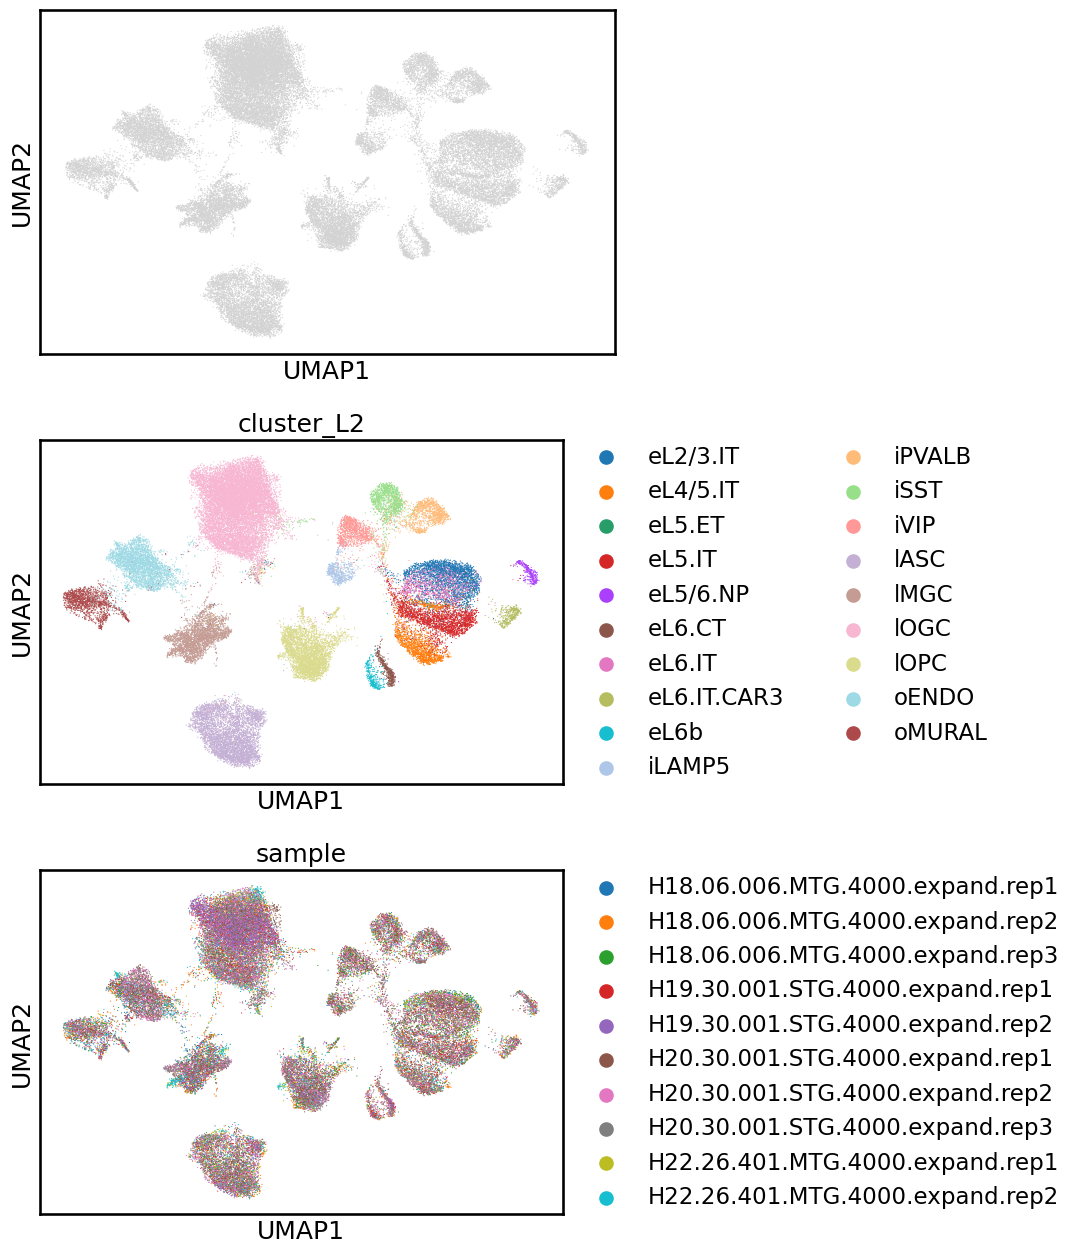

In [30]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cluster_L2', 'sample'], ncols=1)
pass

## Liger

In [32]:
# adatas = []
# for i in chosen_slices:
#    adatas.append(adata.raw.to_adata()[adata.obs['donor_slice'] == i, :])
#    adatas[-1].obs.index.name = 'cell_names'
#    adatas[-1].var.index.name = 'gene_names'
#    adatas[-1].uns['sample_name'] = i
for i in adatas:
    i.uns['sample_name'] = i.obs['sample'].unique().item()
liger = pyliger.create_liger(adatas)

Removing 548 genes not expressing in H22.26.401.MTG.4000.expand.rep1.
Removing 548 genes not expressing in H22.26.401.MTG.4000.expand.rep2.
Removing 548 genes not expressing in H20.30.001.STG.4000.expand.rep1.
Removing 548 genes not expressing in H20.30.001.STG.4000.expand.rep2.
Removing 548 genes not expressing in H20.30.001.STG.4000.expand.rep3.


In [33]:
pyliger.normalize(liger)
pyliger.select_genes(liger)
pyliger.scale_not_center(liger)
pyliger.optimize_ALS(liger, k = 20)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:59<00:00,  9.99s/it]


In [34]:
pyliger.quantile_norm(liger)

In [35]:
adata.obsm['X_liger'] = np.vstack([adata.obsm["H_norm"] for adata in liger.adata_list])

In [36]:
sc.pp.neighbors(adata, use_rep='X_liger', metric='cosine')
sc.tl.umap(adata)

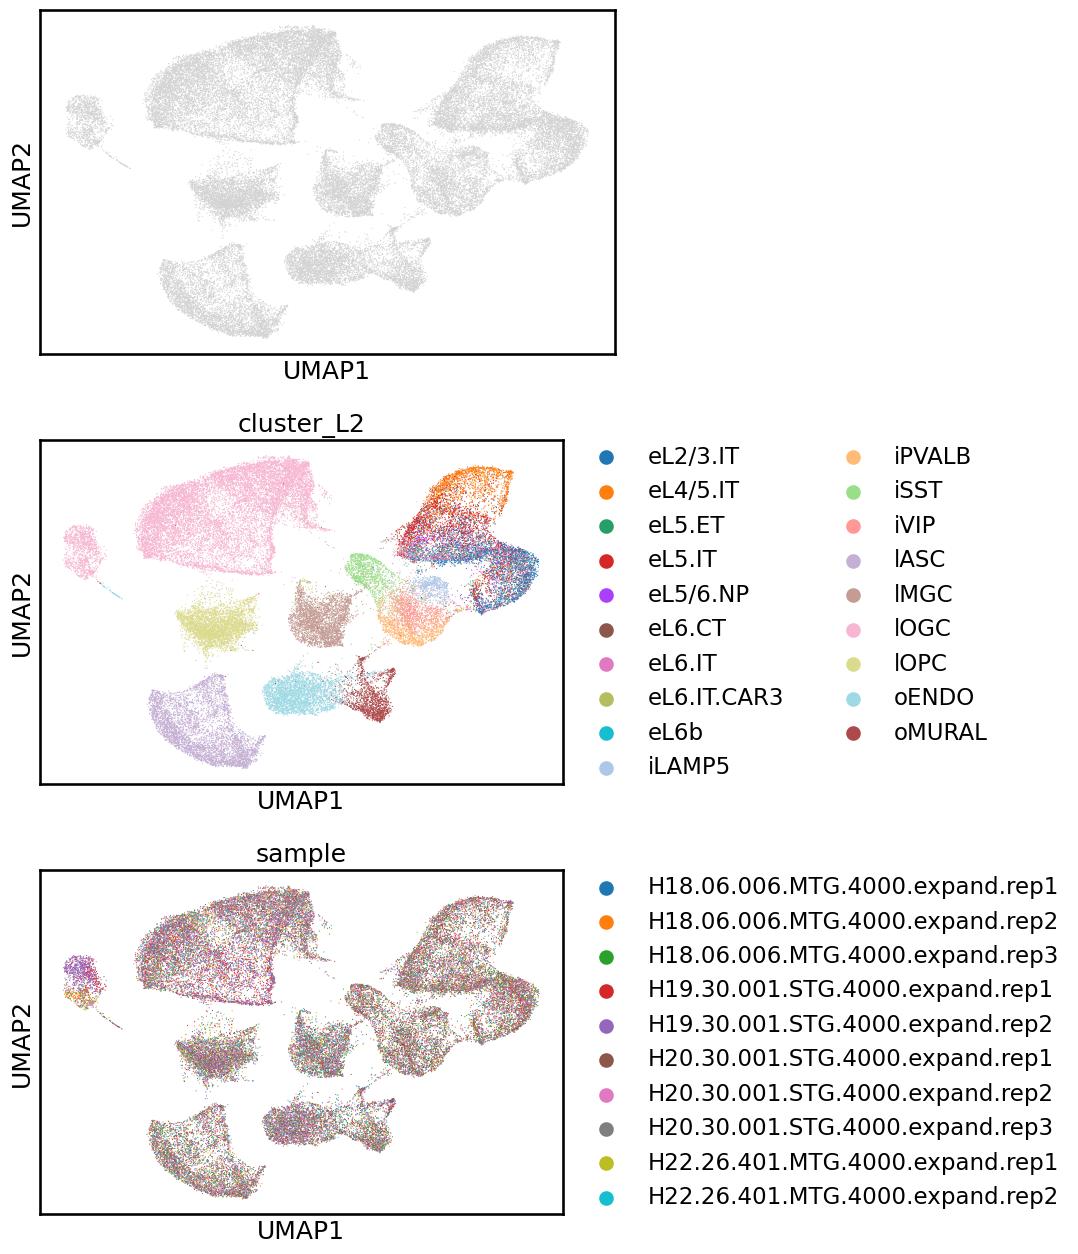

In [37]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cluster_L2', 'sample'], ncols=1)
pass

## Scanorama

In [45]:
adatas = []

ids = ["H18.06.006.MTG.4000.expand.rep1",
       "H18.06.006.MTG.4000.expand.rep2",
       "H18.06.006.MTG.4000.expand.rep3",
       "H22.26.401.MTG.4000.expand.rep1",
       "H22.26.401.MTG.4000.expand.rep2",
       "H19.30.001.STG.4000.expand.rep1",
       "H19.30.001.STG.4000.expand.rep2",
       "H20.30.001.STG.4000.expand.rep1",
       "H20.30.001.STG.4000.expand.rep2",
       "H20.30.001.STG.4000.expand.rep3"]

for id in ids:
    data_dir = '../../data/human-brain/'
    obs = pd.read_csv(os.path.join(data_dir, f"{id}.features.csv"), index_col=0)
    var = pd.read_csv(os.path.join(data_dir, f"{id}.genes.csv"), index_col=0)
    data = pd.read_csv(os.path.join(data_dir, f"{id}.matrix.csv"))

    temp_adata = sc.AnnData(X=sp.sparse.csr_matrix((data['val'], (data['col'] - 1, data['row'] - 1)), 
                                               shape=(len(obs), len(var))),
                       obs=obs,
                       var=var)
    temp_adata.obs['sample'] = id
    adatas.append(temp_adata)

In [46]:
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 3999 genes among all datasets
[[0.         0.82621551 0.68068331 0.03124277 0.01366743 0.2217477
  0.07325887 0.01412615 0.01786081 0.00229961]
 [0.         0.         0.63652393 0.06803981 0.02164009 0.37662875
  0.16959209 0.02298289 0.02002472 0.00587034]
 [0.         0.         0.         0.02221708 0.00541002 0.30031024
  0.14382872 0.01711491 0.00184767 0.00153139]
 [0.         0.         0.         0.         0.81691344 0.00254571
  0.00208285 0.14702526 0.25354137 0.21796835]
 [0.         0.         0.         0.         0.         0.00256264
  0.00341686 0.29157175 0.11930524 0.33997722]
 [0.         0.         0.         0.         0.         0.
  0.72864529 0.01401793 0.00492712 0.00331802]
 [0.         0.         0.         0.         0.         0.
  0.         0.02493888 0.00923835 0.00816743]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.49846028 0.63067892]
 [0.         0.         0.         0.         0.         0.
  0.     

In [47]:
adata.obsm['X_scanorama'] = np.vstack([corrected[i].obsm['X_scanorama'] for i in range(len(adatas))])

In [50]:
sc.pp.neighbors(adata, use_rep='X_scanorama', metric='cosine')
sc.tl.umap(adata)

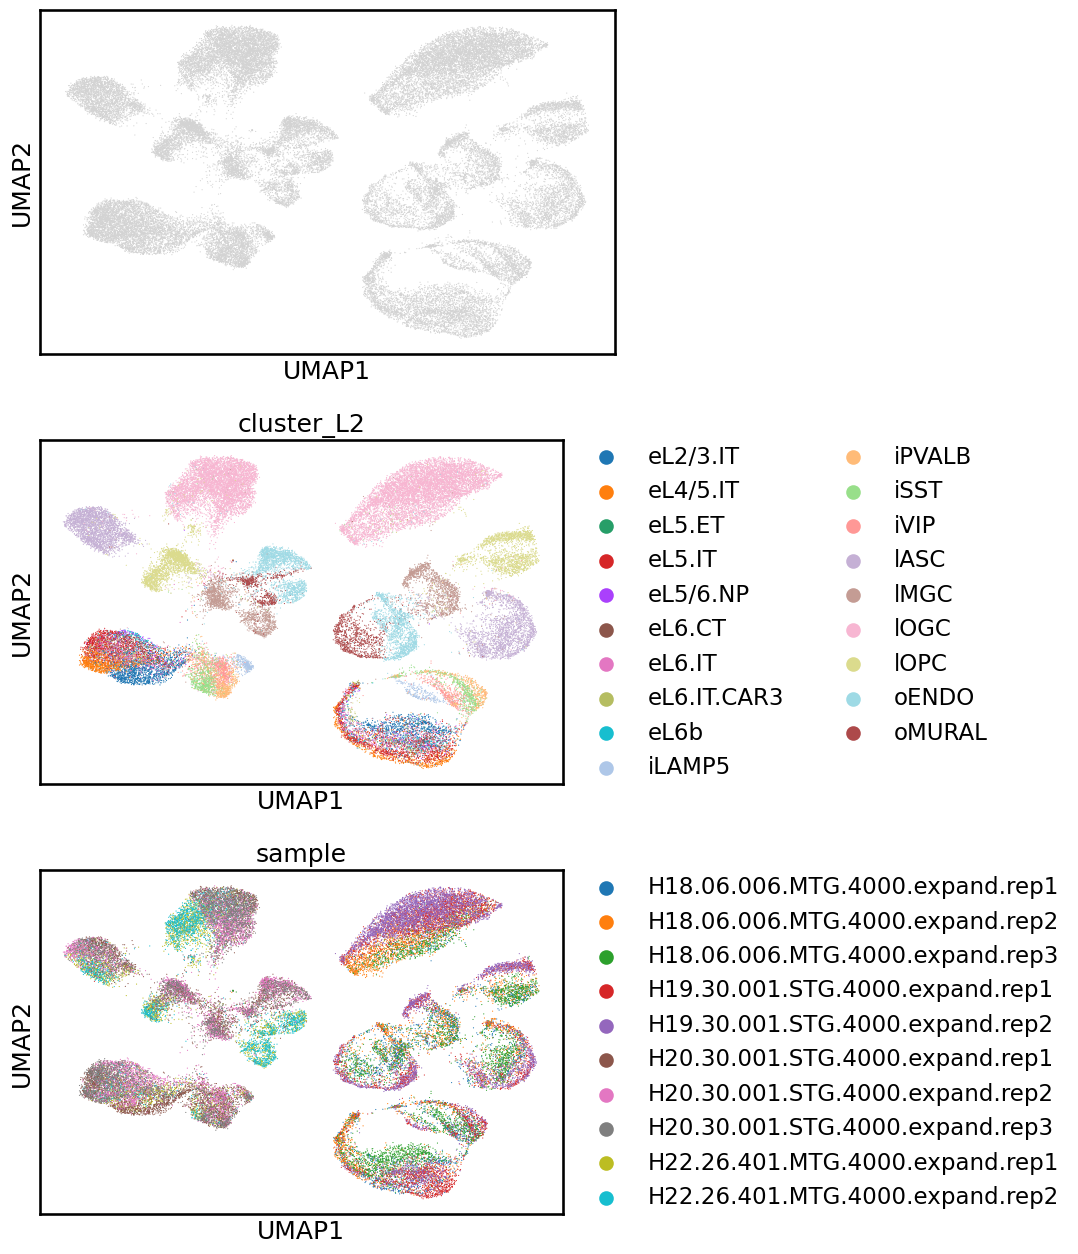

In [51]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cluster_L2', 'sample'], ncols=1)
pass

## Scoring and plotting 

In [52]:
adata.write("output/human-brain-4000-integration.h5ad")